# 🚀 Modelo de Predicción de Tiempo de Respuesta
## Juego de Naves Matemáticas - Modo Infinito Adaptativo

Este notebook construye y compara múltiples modelos de Machine Learning para predecir el tiempo de respuesta del jugador, permitiendo crear un modo infinito donde el tiempo se adapta dinámicamente.

## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

# Modelos de ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para guardar el modelo
import joblib

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Cargar y Preparar Datos

In [2]:
# Cargar datos
with open('1000registros.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"📊 Total de registros: {len(df)}")
print(f"\n📋 Columnas disponibles:")
print(df.columns.tolist())
df.head()

📊 Total de registros: 1000

📋 Columnas disponibles:
['nivel_actual', 'vidas_actuales', 'puntaje_actual', 'respuestas_correctas_acumuladas', 'tiempo_respuesta_pregunta', 'numero_1', 'numero_2', 'signo_operacional', 'resultado_operacional']


,nivel_actual,vidas_actuales,puntaje_actual,respuestas_correctas_acumuladas,tiempo_respuesta_pregunta,numero_1,numero_2,signo_operacional,resultado_operacional
0,1,5,10,1,3.616667,10,10,/,1
1,1,5,20,2,1.333333,8,2,+,10
2,1,5,30,3,2.150000,2,6,+,8
3,2,5,40,4,1.716667,39,23,+,62
4,2,5,35,4,1.850000,47,13,+,60


In [3]:
# Estadísticas descriptivas
print("📈 Estadísticas del tiempo de respuesta:")
print(df['tiempo_respuesta_pregunta'].describe())

📈 Estadísticas del tiempo de respuesta:
count    1000.000000
mean        2.335250
std         0.943453
min         0.833333
25%         1.683333
50%         2.283333
75%         2.900000
max         5.400000
Name: tiempo_respuesta_pregunta, dtype: float64


## 3. Preprocesamiento de Datos

In [4]:
# Codificar el signo operacional
le = LabelEncoder()
df['signo_encoded'] = le.fit_transform(df['signo_operacional'])

print("🔢 Codificación de signos operacionales:")
for i, sign in enumerate(le.classes_):
    print(f"   {sign} → {i}")

# Guardar el encoder para uso futuro
joblib.dump(le, 'signo_encoder.pkl')
print("\n💾 Encoder guardado como 'signo_encoder.pkl'")

🔢 Codificación de signos operacionales:
   * → 0
   + → 1
   - → 2
   / → 3

💾 Encoder guardado como 'signo_encoder.pkl'


In [5]:
# Variables seleccionadas para el modelo (sin numero_2)
FEATURES = [
    'signo_encoded',
    'respuestas_correctas_acumuladas',
    'vidas_actuales',
    'nivel_actual'
]

TARGET = 'tiempo_respuesta_pregunta'

print(f"🎯 Variables predictoras: {FEATURES}")
print(f"🎯 Variable objetivo: {TARGET}")

🎯 Variables predictoras: ['signo_encoded', 'respuestas_correctas_acumuladas', 'vidas_actuales', 'nivel_actual']
🎯 Variable objetivo: tiempo_respuesta_pregunta


In [6]:
# Preparar X e y
X = df[FEATURES]
y = df[TARGET]

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Datos de entrenamiento: {len(X_train)} registros")
print(f"📊 Datos de prueba: {len(X_test)} registros")

📊 Datos de entrenamiento: 800 registros
📊 Datos de prueba: 200 registros


In [7]:
# Escalar datos (necesario para algunos modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar el scaler
joblib.dump(scaler, 'feature_scaler.pkl')
print("💾 Scaler guardado como 'feature_scaler.pkl'")

💾 Scaler guardado como 'feature_scaler.pkl'


## 4. Entrenamiento de Múltiples Modelos

In [8]:
# Definir modelos a comparar
modelos = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

print(f"🤖 Se evaluarán {len(modelos)} modelos diferentes")

🤖 Se evaluarán 8 modelos diferentes


In [9]:
# Entrenar y evaluar cada modelo
resultados = []

for nombre, modelo in modelos.items():
    print(f"\n⏳ Entrenando: {nombre}...")
    
    # Usar datos escalados para SVR y KNN
    if nombre in ['SVR', 'KNN']:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({
        'Modelo': nombre,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })
    
    print(f"   ✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

print("\n🎉 Entrenamiento completado!")


⏳ Entrenando: Linear Regression...
   ✅ RMSE: 0.8079 | MAE: 0.6058 | R²: 0.2620

⏳ Entrenando: Ridge Regression...
   ✅ RMSE: 0.8079 | MAE: 0.6057 | R²: 0.2620

⏳ Entrenando: Lasso Regression...
   ✅ RMSE: 0.8243 | MAE: 0.6268 | R²: 0.2317

⏳ Entrenando: Decision Tree...
   ✅ RMSE: 0.4218 | MAE: 0.1689 | R²: 0.7989

⏳ Entrenando: Random Forest...
   ✅ RMSE: 0.4193 | MAE: 0.1613 | R²: 0.8012

⏳ Entrenando: Gradient Boosting...
   ✅ RMSE: 0.4142 | MAE: 0.1482 | R²: 0.8060

⏳ Entrenando: SVR...
   ✅ RMSE: 0.6486 | MAE: 0.3518 | R²: 0.5244

⏳ Entrenando: KNN...
   ✅ RMSE: 0.4729 | MAE: 0.1544 | R²: 0.7471

🎉 Entrenamiento completado!


## 5. Comparación de Modelos

In [10]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('RMSE')

print("\n📊 RANKING DE MODELOS (ordenados por RMSE - menor es mejor):")
print("=" * 60)
df_resultados


📊 RANKING DE MODELOS (ordenados por RMSE - menor es mejor):


,Modelo,RMSE,MAE,R²
5,Gradient Boosting,0.414222,0.148230,0.806000
4,Random Forest,0.419330,0.161256,0.801186
3,Decision Tree,0.421759,0.168872,0.798876
7,KNN,0.472948,0.154383,0.747092
6,SVR,0.648572,0.351767,0.524389
1,Ridge Regression,0.807907,0.605722,0.261997
0,Linear Regression,0.807930,0.605816,0.261956
2,Lasso Regression,0.824333,0.626829,0.231682


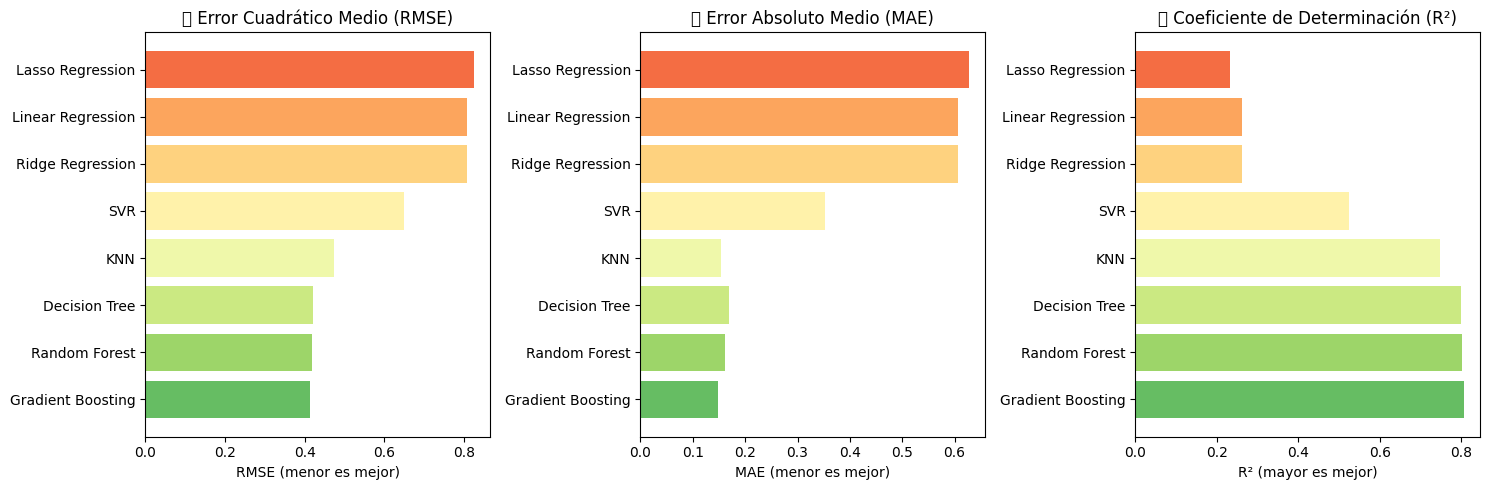

💾 Gráfico guardado como 'comparacion_modelos.png'


In [11]:
# Visualización de comparación
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(df_resultados)))
axes[0].barh(df_resultados['Modelo'], df_resultados['RMSE'], color=colors)
axes[0].set_xlabel('RMSE (menor es mejor)')
axes[0].set_title('🎯 Error Cuadrático Medio (RMSE)')

# MAE
axes[1].barh(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[1].set_xlabel('MAE (menor es mejor)')
axes[1].set_title('📏 Error Absoluto Medio (MAE)')

# R²
colors_r2 = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(df_resultados)))
axes[2].barh(df_resultados['Modelo'], df_resultados['R²'], color=colors_r2[::-1])
axes[2].set_xlabel('R² (mayor es mejor)')
axes[2].set_title('📈 Coeficiente de Determinación (R²)')

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Gráfico guardado como 'comparacion_modelos.png'")

## 6. Selección del Mejor Modelo

In [12]:
# Identificar el mejor modelo
mejor_modelo_nombre = df_resultados.iloc[0]['Modelo']
mejor_rmse = df_resultados.iloc[0]['RMSE']
mejor_r2 = df_resultados.iloc[0]['R²']

print(f"\n🏆 MEJOR MODELO: {mejor_modelo_nombre}")
print(f"   📊 RMSE: {mejor_rmse:.4f} segundos")
print(f"   📊 R²: {mejor_r2:.4f}")


🏆 MEJOR MODELO: Gradient Boosting
   📊 RMSE: 0.4142 segundos
   📊 R²: 0.8060


In [13]:
# Reentrenar el mejor modelo con todos los datos
mejor_modelo = modelos[mejor_modelo_nombre]

if mejor_modelo_nombre in ['SVR', 'KNN']:
    X_full_scaled = scaler.fit_transform(X)
    mejor_modelo.fit(X_full_scaled, y)
else:
    mejor_modelo.fit(X, y)

# Guardar el modelo
joblib.dump(mejor_modelo, 'mejor_modelo_tiempo.pkl')
print(f"💾 Modelo guardado como 'mejor_modelo_tiempo.pkl'")

💾 Modelo guardado como 'mejor_modelo_tiempo.pkl'


## 7. Importancia de Variables (si aplica)

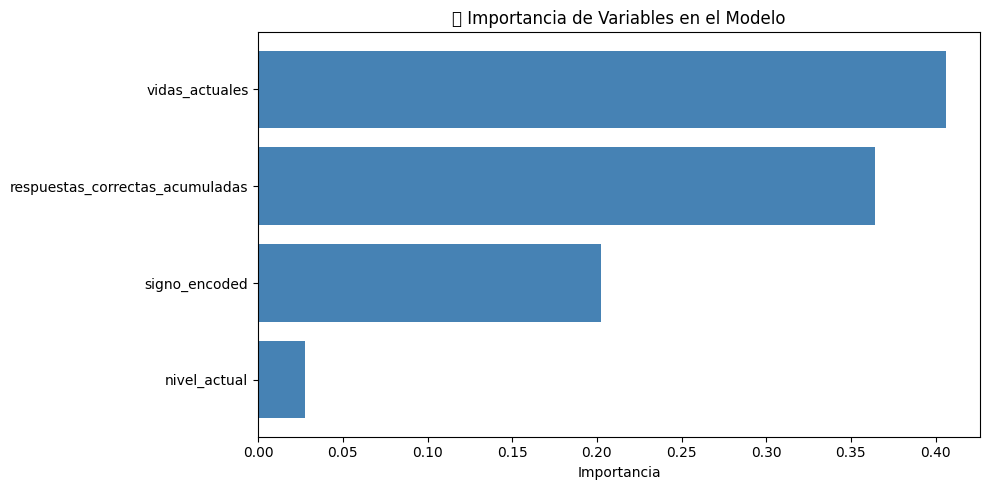

                          Variable  Importancia
2                   vidas_actuales     0.405949
1  respuestas_correctas_acumuladas     0.364001
0                    signo_encoded     0.202350
3                     nivel_actual     0.027700


In [14]:
# Mostrar importancia de variables (para modelos basados en árboles)
if hasattr(mejor_modelo, 'feature_importances_'):
    importancias = pd.DataFrame({
        'Variable': FEATURES,
        'Importancia': mejor_modelo.feature_importances_
    }).sort_values('Importancia', ascending=False)
    
    plt.figure(figsize=(10, 5))
    plt.barh(importancias['Variable'], importancias['Importancia'], color='steelblue')
    plt.xlabel('Importancia')
    plt.title('🔍 Importancia de Variables en el Modelo')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('importancia_variables.png', dpi=150)
    plt.show()
    print(importancias)
else:
    print("ℹ️ El modelo seleccionado no proporciona importancia de variables directamente.")

## 8. Función de Predicción para el Juego

In [15]:
# Definir la función que se usará en el juego
def predecir_tiempo_respuesta(signo, respuestas_correctas, vidas, nivel):
    """
    Predice el tiempo de respuesta esperado del jugador.
    
    Args:
        signo: str - El signo operacional ('+', '-', '*', '/')
        respuestas_correctas: int - Número de respuestas correctas acumuladas
        vidas: int - Vidas actuales del jugador
        nivel: int - Nivel actual del juego
    
    Returns:
        float - Tiempo predicho en segundos
    """
    # Codificar el signo
    signo_map = {'+': 0, '-': 1, '*': 2, '/': 3}  # Ajustar según el encoder
    signo_encoded = signo_map.get(signo, 0)
    
    # Crear array de features
    features = np.array([[signo_encoded, respuestas_correctas, vidas, nivel]])
    
    # Cargar modelo y predecir
    modelo = joblib.load('mejor_modelo_tiempo.pkl')
    tiempo_predicho = modelo.predict(features)[0]
    
    return max(tiempo_predicho, 1.0)  # Mínimo 1 segundo

# Ejemplo de uso
print("\n🎮 Ejemplos de predicción:")
print(f"   Operación '+', 5 correctas, 3 vidas, nivel 2: {predecir_tiempo_respuesta('+', 5, 3, 2):.2f}s")
print(f"   Operación '/', 10 correctas, 2 vidas, nivel 3: {predecir_tiempo_respuesta('/', 10, 2, 3):.2f}s")
print(f"   Operación '*', 2 correctas, 5 vidas, nivel 1: {predecir_tiempo_respuesta('*', 2, 5, 1):.2f}s")


🎮 Ejemplos de predicción:
   Operación '+', 5 correctas, 3 vidas, nivel 2: 1.94s
   Operación '/', 10 correctas, 2 vidas, nivel 3: 3.62s
   Operación '*', 2 correctas, 5 vidas, nivel 1: 3.41s


## 9. Sistema de Tiempo Adaptativo

In [16]:
class TiempoAdaptativo:
    """
    Sistema de tiempo adaptativo para el modo infinito.
    Si el jugador responde rápido → reduce el tiempo
    Si el jugador responde lento → aumenta el tiempo
    """
    
    def __init__(self, tiempo_base=5.0, min_tiempo=2.0, max_tiempo=10.0):
        self.tiempo_base = tiempo_base
        self.tiempo_actual = tiempo_base
        self.min_tiempo = min_tiempo
        self.max_tiempo = max_tiempo
        self.factor_ajuste = 0.5  # Segundos a ajustar
        self.modelo = joblib.load('mejor_modelo_tiempo.pkl')
        self.historial = []
    
    def obtener_tiempo_para_pregunta(self, signo, respuestas_correctas, vidas, nivel):
        """
        Calcula el tiempo para la siguiente pregunta basándose en:
        1. Predicción del modelo ML
        2. Historial reciente del jugador
        """
        # Predicción del modelo
        signo_map = {'+': 0, '-': 1, '*': 2, '/': 3}
        features = np.array([[signo_map.get(signo, 0), respuestas_correctas, vidas, nivel]])
        tiempo_predicho = self.modelo.predict(features)[0]
        
        # Ajustar basándose en historial reciente
        if len(self.historial) >= 3:
            promedio_reciente = np.mean(self.historial[-3:])
            # Combinar predicción con historial (70% predicción, 30% historial)
            tiempo_final = 0.7 * tiempo_predicho + 0.3 * promedio_reciente
        else:
            tiempo_final = tiempo_predicho
        
        # Aplicar límites
        tiempo_final = max(self.min_tiempo, min(self.max_tiempo, tiempo_final))
        
        return round(tiempo_final, 1)
    
    def registrar_respuesta(self, tiempo_usado, fue_correcta):
        """
        Registra el tiempo que tardó el jugador y ajusta el sistema.
        """
        self.historial.append(tiempo_usado)
        
        # Mantener solo los últimos 10 registros
        if len(self.historial) > 10:
            self.historial.pop(0)
        
        # Ajustar tiempo base según rendimiento
        if fue_correcta and tiempo_usado < self.tiempo_actual * 0.5:
            # Respondió muy rápido y correcto → reducir tiempo
            self.tiempo_actual = max(self.min_tiempo, 
                                     self.tiempo_actual - self.factor_ajuste)
        elif not fue_correcta or tiempo_usado > self.tiempo_actual * 0.9:
            # Respondió lento o incorrecto → aumentar tiempo
            self.tiempo_actual = min(self.max_tiempo, 
                                     self.tiempo_actual + self.factor_ajuste)

# Demostración del sistema
print("\n🎮 DEMOSTRACIÓN DEL SISTEMA ADAPTATIVO")
print("=" * 50)

sistema = TiempoAdaptativo(tiempo_base=5.0)

# Simular una partida
escenarios = [
    ('+', 0, 5, 1, 2.0, True),   # Respuesta rápida y correcta
    ('-', 1, 5, 1, 1.5, True),   # Muy rápida
    ('*', 2, 5, 1, 4.5, True),   # Normal
    ('/', 3, 4, 2, 6.0, False),  # Lenta e incorrecta
    ('+', 3, 4, 2, 3.0, True),   # Rápida
]

for signo, correctas, vidas, nivel, tiempo_usado, fue_correcta in escenarios:
    tiempo_asignado = sistema.obtener_tiempo_para_pregunta(signo, correctas, vidas, nivel)
    sistema.registrar_respuesta(tiempo_usado, fue_correcta)
    resultado = "✅" if fue_correcta else "❌"
    print(f"Pregunta {signo}: Tiempo asignado={tiempo_asignado}s, Usado={tiempo_usado}s {resultado}")


🎮 DEMOSTRACIÓN DEL SISTEMA ADAPTATIVO
Pregunta +: Tiempo asignado=2.6s, Usado=2.0s ✅
Pregunta -: Tiempo asignado=2.0s, Usado=1.5s ✅
Pregunta *: Tiempo asignado=3.4s, Usado=4.5s ✅
Pregunta /: Tiempo asignado=2.8s, Usado=6.0s ❌
Pregunta +: Tiempo asignado=3.4s, Usado=3.0s ✅


## 10. Código para Integrar en el Juego

In [17]:
# Código listo para copiar al juego
codigo_integracion = '''
# ============================================
# CÓDIGO PARA INTEGRAR EN main.py
# ============================================

import joblib
import numpy as np

class TiempoAdaptativo:
    """
    Sistema de tiempo adaptativo para el modo infinito.
    """
    
    def __init__(self, tiempo_base=5.0, min_tiempo=2.0, max_tiempo=10.0):
        self.tiempo_base = tiempo_base
        self.tiempo_actual = tiempo_base
        self.min_tiempo = min_tiempo
        self.max_tiempo = max_tiempo
        self.factor_ajuste = 0.5
        try:
            self.modelo = joblib.load('mejor_modelo_tiempo.pkl')
            self.usar_modelo = True
        except:
            self.usar_modelo = False
        self.historial = []
    
    def obtener_tiempo(self, signo, respuestas_correctas, vidas, nivel):
        if not self.usar_modelo:
            return self.tiempo_actual
        
        signo_map = {'+': 0, '-': 1, '*': 2, '/': 3}
        features = np.array([[signo_map.get(signo, 0), respuestas_correctas, vidas, nivel]])
        tiempo_predicho = self.modelo.predict(features)[0]
        
        if len(self.historial) >= 3:
            promedio = np.mean(self.historial[-3:])
            tiempo_final = 0.7 * tiempo_predicho + 0.3 * promedio
        else:
            tiempo_final = tiempo_predicho
        
        return max(self.min_tiempo, min(self.max_tiempo, round(tiempo_final, 1)))
    
    def registrar_respuesta(self, tiempo_usado, fue_correcta):
        self.historial.append(tiempo_usado)
        if len(self.historial) > 10:
            self.historial.pop(0)
        
        if fue_correcta and tiempo_usado < self.tiempo_actual * 0.5:
            self.tiempo_actual = max(self.min_tiempo, self.tiempo_actual - self.factor_ajuste)
        elif not fue_correcta or tiempo_usado > self.tiempo_actual * 0.9:
            self.tiempo_actual = min(self.max_tiempo, self.tiempo_actual + self.factor_ajuste)

# Uso en el juego:
# sistema_tiempo = TiempoAdaptativo()
# tiempo_pregunta = sistema_tiempo.obtener_tiempo(operacion, correctas, vidas, nivel)
# ... después de responder ...
# sistema_tiempo.registrar_respuesta(tiempo_usado, fue_correcta)
'''

print(codigo_integracion)

# Guardar el código en un archivo
with open('tiempo_adaptativo_integration.py', 'w') as f:
    f.write(codigo_integracion)
print("\n💾 Código guardado en 'tiempo_adaptativo_integration.py'")


# ============================================
# CÓDIGO PARA INTEGRAR EN main.py
# ============================================

import joblib
import numpy as np

class TiempoAdaptativo:
    """
    Sistema de tiempo adaptativo para el modo infinito.
    """

    def __init__(self, tiempo_base=5.0, min_tiempo=2.0, max_tiempo=10.0):
        self.tiempo_base = tiempo_base
        self.tiempo_actual = tiempo_base
        self.min_tiempo = min_tiempo
        self.max_tiempo = max_tiempo
        self.factor_ajuste = 0.5
        try:
            self.modelo = joblib.load('mejor_modelo_tiempo.pkl')
            self.usar_modelo = True
        except:
            self.usar_modelo = False
        self.historial = []

    def obtener_tiempo(self, signo, respuestas_correctas, vidas, nivel):
        if not self.usar_modelo:
            return self.tiempo_actual

        signo_map = {'+': 0, '-': 1, '*': 2, '/': 3}
        features = np.array([[signo_map.get(signo, 0), respuestas_correctas, vidas, 

## 📋 Resumen Final

In [18]:
print("\n" + "="*60)
print("📋 RESUMEN FINAL")
print("="*60)
print(f"\n✅ Modelos evaluados: {len(modelos)}")
print(f"🏆 Mejor modelo: {mejor_modelo_nombre}")
print(f"📊 RMSE: {mejor_rmse:.4f} segundos")
print(f"📊 R²: {mejor_r2:.4f}")
print(f"\n🎯 Variables utilizadas:")
for f in FEATURES:
    print(f"   • {f}")
print(f"\n💾 Archivos generados:")
print("   • mejor_modelo_tiempo.pkl")
print("   • signo_encoder.pkl")
print("   • feature_scaler.pkl")
print("   • comparacion_modelos.png")
print("   • tiempo_adaptativo_integration.py")
print("\n🚀 ¡Listo para integrar en el juego!")


📋 RESUMEN FINAL

✅ Modelos evaluados: 8
🏆 Mejor modelo: Gradient Boosting
📊 RMSE: 0.4142 segundos
📊 R²: 0.8060

🎯 Variables utilizadas:
   • signo_encoded
   • respuestas_correctas_acumuladas
   • vidas_actuales
   • nivel_actual

💾 Archivos generados:
   • mejor_modelo_tiempo.pkl
   • signo_encoder.pkl
   • feature_scaler.pkl
   • comparacion_modelos.png
   • tiempo_adaptativo_integration.py

🚀 ¡Listo para integrar en el juego!
